## Creating user features using clustering techniques

In order to improve our model we want to look for common features among users and cluster them. The technique is meant to build a recommendation system within our current model. If the model is able to discern groupings for customers as a baseline to recommendations we can improve our model significantly. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Load master dataframe

In [2]:
master_df = pd.read_csv('/project/data/int/master_df.csv', index_col=0)

In [3]:
master_df = master_df.drop_duplicates(['order_id', 'order_item_id']).dropna().reset_index(drop=True)

In [4]:
master_df.product_category_name.value_counts()[:20]

bed_bath_table              10803
health_beauty                9375
sports_leisure               8359
furniture_decor              8057
computers_accessories        7586
housewares                   6738
watches_gifts                5791
telephony                    4374
garden_tools                 4228
auto                         4089
toys                         3964
cool_stuff                   3643
perfumery                    3314
baby                         2949
electronics                  2617
stationery                   2438
fashion_bags_accessories     1968
pet_shop                     1894
office_furniture             1648
consoles_games               1075
Name: product_category_name, dtype: int64

### Create user product interaction

In [5]:
item_features = master_df[['customer_unique_id', 'customer_id','product_id', 'order_id', 'product_category_name', 'order_item_id', 'seller_id', 'review_score', 
                          'review_comment_message', 'seller_city', 'seller_state', 'price']]

In [6]:
# Create product_count column for the rating
item_features['product_category_count'] = item_features[['product_category_name', 'customer_unique_id', 'order_item_id']]\
                                                            .groupby(['customer_unique_id', 'product_category_name'])['order_item_id']\
                                                            .transform('count')

/tmp/ipykernel_122/4284255273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_features['product_category_count'] = item_features[['product_category_name', 'customer_unique_id', 'order_item_id']]\


In [7]:
user_to_product_category = item_features[['product_category_name', 'customer_unique_id', 'product_category_count']]\
                                        .sort_values(by='customer_unique_id')\
                                        .reset_index(drop=True)

In [8]:
user_to_product_category['product_count'] = 1

In [9]:
user_to_product_category = user_to_product_category.drop(['product_category_count'], axis=1)

In [10]:
def get_user_list(df, user_column):
    """
    
    creating a list of user from dataframe df, user_column is a column 
    consisting of users in the dataframe df
    
    """
    
    return np.sort(df[user_column].unique())

def get_item_list(df, item_name_column):
    
    """
    
    creating a list of items from dataframe df, item_column is a column 
    consisting of items in the dataframe df
    
    return to item_id_list and item_id2name_mapping
    
    """
    
    item_list = df[item_name_column].unique()
    
    
    return item_list

In [11]:
def id_mappings(user_list, item_list):
    """
    
    Create id mappings to convert user_id, item_id, and feature_id
    
    """
    user_to_index_mapping = {}
    index_to_user_mapping = {}
    for user_index, user_id in enumerate(user_list):
        user_to_index_mapping[user_id] = user_index
        index_to_user_mapping[user_index] = user_id
        
    item_to_index_mapping = {}
    index_to_item_mapping = {}
    for item_index, item_id in enumerate(item_list):
        item_to_index_mapping[item_id] = item_index
        index_to_item_mapping[item_index] = item_id
        

    return user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping

In [12]:
from scipy import sparse
def get_interaction_matrix(df, df_column_as_row, df_column_as_col, df_column_as_value, row_indexing_map, 
                          col_indexing_map):
    
    row = df[df_column_as_row].apply(lambda x: row_indexing_map[x]).values
    col = df[df_column_as_col].apply(lambda x: col_indexing_map[x]).values
    value = df[df_column_as_value].values
    
    return sparse.coo_matrix((value, (row, col)), shape = (len(row_indexing_map), len(col_indexing_map)))

In [13]:
user_list = get_user_list(user_to_product_category, 'customer_unique_id')
item_list = get_item_list(user_to_product_category, 'product_category_name')

In [14]:
user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping = id_mappings(user_list, item_list)

In [15]:
user_to_product_category_interaction = get_interaction_matrix(user_to_product_category, "customer_unique_id", 
                                                           "product_category_name", "product_count", 
                                                           user_to_index_mapping, item_to_index_mapping)

In [16]:
product_category_to_user_interaction = get_interaction_matrix(user_to_product_category, "product_category_name", 
                                                             "customer_unique_id", "product_count",
                                                             item_to_index_mapping, user_to_index_mapping)

### User clustering

Clustering will be conducted using kmeans which uses distance based algorithms to decide clusters using maximum marginality between edge cases.

In [17]:
import scipy.sparse

table = pd.DataFrame(user_to_product_category_interaction.todense())

In [18]:
table1 = pd.DataFrame(product_category_to_user_interaction.todense())

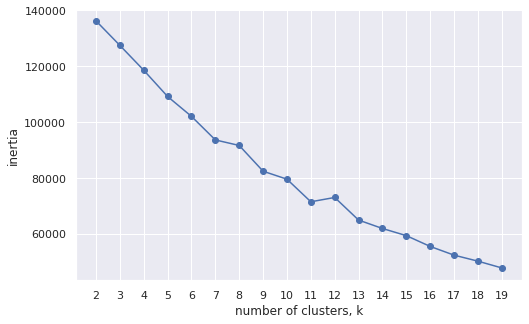

In [19]:
from sklearn.cluster import KMeans

# Create table of values only
x_cols = table.values
ks = range(2, 20)
inertias = []

for k in ks:
    # create a KMeans instance with k clusters
    kmeans = KMeans(n_clusters = k, random_state=3)
    # fit model to samples
    kmeans.fit(x_cols)
    # append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)

# plot ks vs inertias
plt.figure(figsize=(8,5))
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

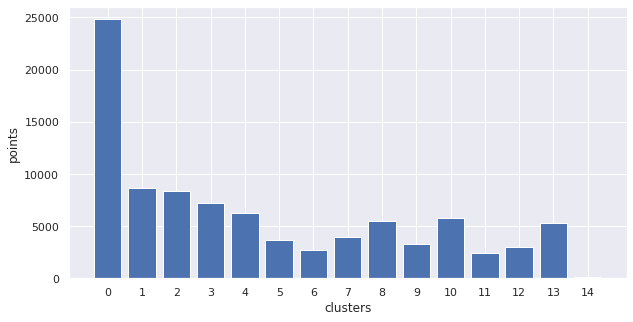

In [20]:
from sklearn.cluster import KMeans
x_cols = table.values
# create a KMeans instance with k clusters
model = KMeans(n_clusters = 15, random_state=3)
# fit model to samples
model.fit(x_cols)
# Create labels for data
labels = model.predict(x_cols)

# create bar chart
clusters, npoints = np.unique(labels, return_counts=True)
plt.figure(figsize=(10,5))
plt.bar(clusters, npoints)
plt.xticks(clusters)
plt.ylabel('points')
plt.xlabel('clusters')
plt.show()

In [21]:
labels = pd.DataFrame({'cluster_id': labels})

In [22]:
table.index.name = 'customer_unique_id'

In [23]:
table = table.reset_index()

In [24]:
df = pd.concat([table.customer_unique_id, \
                labels], axis=1, sort=False)

In [25]:
df = df.replace({"customer_unique_id": index_to_user_mapping})

In [26]:
df

,customer_unique_id,cluster_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2
2,0000f46a3911fa3c0805444483337064,0
3,0000f6ccb0745a6a4b88665a16c9f078,7
4,0004aac84e0df4da2b147fca70cf8255,7
...,...,...
91028,fffcf5a5ff07b0908bd4e2dbc735a684,2
91029,fffea47cd6d3cc0a88bd621562a9d061,6
91030,ffff371b4d645b6ecea244b27531430a,0
91031,ffff5962728ec6157033ef9805bacc48,13


In [27]:
df.head()

,customer_unique_id,cluster_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2
2,0000f46a3911fa3c0805444483337064,0
3,0000f6ccb0745a6a4b88665a16c9f078,7
4,0004aac84e0df4da2b147fca70cf8255,7


In [28]:
item_features_clustered = item_features.merge(df, on = 'customer_unique_id')

In [29]:
# export into interim
item_features_clustered.to_csv(r'/project/data/int/item_features_clustered.csv')